# Импорт пакетов

In [1]:
import pandas as pd
import torch 
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from dataframe import CustomDataset
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
import os

from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose,
    Resize,
    OneOf,
    RandomBrightnessContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    VerticalFlip,
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,

)

from utils import evaluate_model, plot_confusion_matrix

# Дополнительные функции обучения и валидации

In [ ]:
class TrainModelResult():
    def __init__(self, 
                 train_losses: list, 
                 val_losses: list, 
                 train_accuracies: list, 
                 val_accuracies: list):
        self.train_losses = train_losses 
        self.val_losses = val_losses 
        self.train_accuracies = train_accuracies 
        self.val_accuracies = val_accuracies

In [ ]:
def train_model(model, 
                model_name: str, 
                device, 
                num_epochs: int, 
                learning_rate: float, 
                train_loader, 
                val_loader,
                classification_head_name=None,
                class_weights=None) -> TrainModelResult:
    # Определим функцию потерь и оптимизатор
    if class_weights is None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0 # loss в рамках 1 прохода по датасету (одной эпохи)
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # зануляем градиенты перед обработкой очередного батча
            outputs = model(images) # получаем предсказания модели

            loss = criterion(outputs, labels) # получаем выход функции потерь
            loss.backward() # прогоняем градиенты обратно по графу вычиялений от хвоста сети к голове
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #! добавить клипинк для предотвращения взрыва градиентов
            
            optimizer.step() # делаем шаг градиентного спуска (обновляем веса)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader) # средняя ошибка за один проход по данным (за 1 эпоху)
        train_accuracy = correct / total
        # сохраняем данные по эпохе
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Валидация модели
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                    f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                    f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
        scheduler.step(val_loss) # добавляем уменьшене learning rate
    
        # Сохранение лучшей модели на основе валидационной точности
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            if classification_head_name is None:
                torch.save(model.state_dict(), f"best_model_{model_name}.pth")
            else:
                path_to_save = Path(f"{classification_head_name}")
                if not path_to_save.exists():
                    os.mkdir(path_to_save.absolute())
                torch.save(model.state_dict(), f"{path_to_save.absolute()}/best_model_{model_name}.pth")
            print('Saved best model!')
        
        # Сохранение последней актуальной модели
        if classification_head_name is None:
            torch.save(model.state_dict(), f"last_model_{model_name}.pth")
        else:
            path_to_save = Path(f"{classification_head_name}")
            if not path_to_save.exists():
                os.mkdir(path_to_save.absolute())
            torch.save(model.state_dict(), f"{path_to_save.absolute()}/last_model_{model_name}.pth")

    print(f"Training and validation complete!")
    
    return TrainModelResult(train_losses,
                            val_losses,
                            train_accuracies,
                            val_accuracies)

In [ ]:
def plot_train_proces(num_epochs: int,
                      train_losses,
                      val_losses,
                      train_accuracies,
                      val_accuracies,
                      model_name: str,
                      classification_head_name=None):
    # Построим графики
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss vs. Epoch ({model_name})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy vs. Epoch ({model_name})")
    plt.legend()

    plt.show()
    if classification_head_name is None:
        plt.savefig(f".images/{model_name}.jpg")

In [ ]:
def evaluate_model(model, dataloader, device):
    """
    Evaluates a PyTorch model's performance on a given dataset.

    This function runs the model in evaluation mode on the provided dataloader,
    collects predictions, and computes various performance metrics including
    confusion matrix, classification report, accuracy, and weighted F1 score.

    Args:
        model: The PyTorch model to evaluate.
        dataloader: DataLoader containing the evaluation dataset.
        device: The computation device (CPU or GPU) where the model and data should be loaded.

    Returns:
        tuple: A tuple containing:
            - cm (numpy.ndarray): Confusion matrix of model predictions.
            - report (str): Classification report with precision, recall, and F1 score for each class.
            - accuracy (float): Overall accuracy of the model on the dataset.
            - weighted_f1 (float): Weighted F1 score across all classes.
    """
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Макет модели

In [ ]:
class CustomConvNeXtTiny(nn.Module):
    def __init__(self, n_classes: int, classification_head=None, pretrained=True):
        super(CustomConvNeXtTiny, self).__init__()

        self.backbone = models.convnext_tiny(pretrained=pretrained)
        in_features = self.backbone.classifier[-1].in_features
        
        self.classification_head = classification_head
        if self.classification_head is None:
            self.backbone.classifier[-1] = self.classification_head = nn.Sequential(
                nn.Linear(in_features, n_classes)
            )
        else:
            self.backbone.classifier[-1] = classification_head(in_features, n_classes)

    def forward(self, x):
        return self.backbone(x)

# Голова классификации

In [ ]:
class ClassificationHead4(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(ClassificationHead4, self).__init__()
        
        self.classification_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, out_features)
        )
        
    def forward(self, x):
        return self.classification_head(x)

In [2]:
# фиксируем рандомный сид
seed  = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

In [3]:
# детектируем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Задание констант

In [4]:
classes_list = ['healthy', 'multiple_diseases', 'rust', 'scab']

train_csv_file = './data/train/train.csv'
train_images_dir = './data/train/images'
validation_csv_file = './data/validation/validation.csv'
validation_images_dir = './data/validation/images'

batch_size = 64

n_classes = len(classes_list)

# число эпох
num_epochs = 45
learning_rate = 0.0001

WIDTH = 512
HEIGHT = 320

# Извлечение данных (формирование датасетов)

Добавляем аугментацию для лучшего обучения модели.

In [7]:
val_transform = Compose([
                    Resize(height=HEIGHT, width=WIDTH),
                    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                    ToTensorV2()
                ])

val_dataset = CustomDataset(validation_csv_file, 
                            validation_images_dir, 
                            classes_list, 
                            val_transform)

In [8]:
train_transform = Compose([
        Resize(height=HEIGHT, width=WIDTH),
        RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=1),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
        ])

train_dataset = CustomDataset(train_csv_file, 
                              train_images_dir, 
                              classes_list, 
                              train_transform)

# Исследование данных

Class weights: [0.8654891304347826, 5.137096774193548, 0.7288329519450801, 0.7825552825552825]


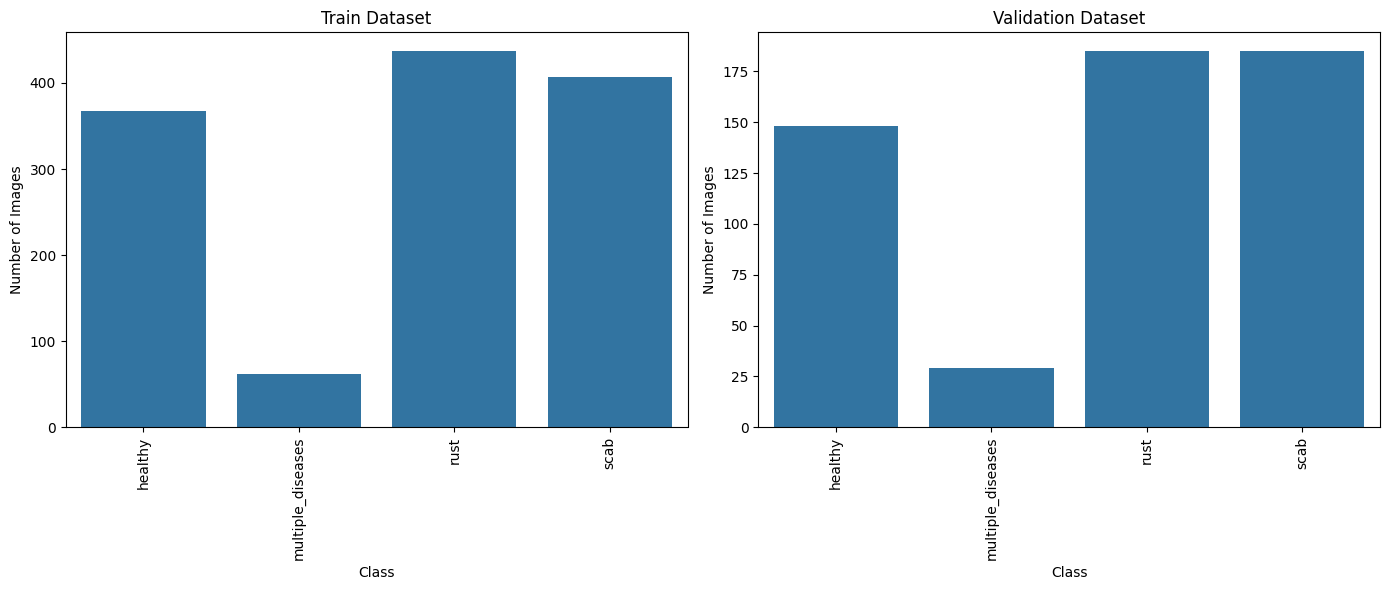

In [22]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1

# посчитаем веса для каждого класса
class_weights = (sum(train_class_counts.tolist()) / (len(classes_list) * train_class_counts)).tolist()
print(f"Class weights: {class_weights}")
class_weights = torch.tensor(class_weights)

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Формирование DataLoaders

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Определяем модель

In [5]:
model = CustomConvNeXtTiny(n_classes=n_classes, classification_head=ClassificationHead4)

/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Baseline модели (без обучения)

Metrics for current model:
Test Accuracy: 0.0530


/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/kaggle-cv/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

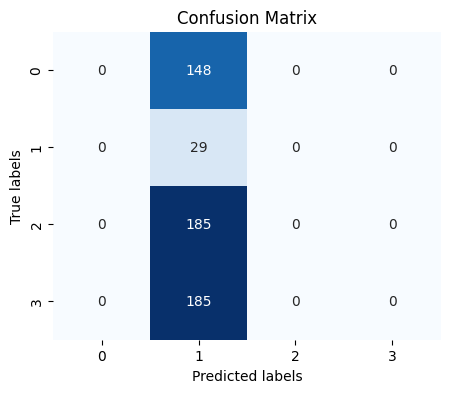

In [20]:
cm, _, accuracy, _ = evaluate_model(model, val_loader, device)
print("Metrics for current model:")
print(f'Test Accuracy: {accuracy:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))

# Обучение и валидация модели

In [23]:
model_train_result = train_model(model,
                                'convnexttiny',
                                device,
                                num_epochs,
                                learning_rate,
                                train_loader,
                                val_loader,
                                classification_head_name='head_4',
                                class_weights=class_weights
                                )

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


Epoch [1/45], Train Loss: 1.2033, Train Accuracy: 0.6036, Val Loss: 0.9111, Val Accuracy: 0.8958
Saved best model!


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


Epoch [2/45], Train Loss: 0.7183, Train Accuracy: 0.9231, Val Loss: 0.5701, Val Accuracy: 0.9086
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


Epoch [3/45], Train Loss: 0.4588, Train Accuracy: 0.9443, Val Loss: 0.4136, Val Accuracy: 0.9141
Saved best model!


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Epoch [4/45], Train Loss: 0.3593, Train Accuracy: 0.9388, Val Loss: 0.4210, Val Accuracy: 0.9141


100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


Epoch [5/45], Train Loss: 0.2812, Train Accuracy: 0.9584, Val Loss: 0.3412, Val Accuracy: 0.9232
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


Epoch [6/45], Train Loss: 0.2049, Train Accuracy: 0.9741, Val Loss: 0.4130, Val Accuracy: 0.9068


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


Epoch [7/45], Train Loss: 0.1600, Train Accuracy: 0.9765, Val Loss: 0.3683, Val Accuracy: 0.8885


100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


Epoch [8/45], Train Loss: 0.1736, Train Accuracy: 0.9717, Val Loss: 0.4090, Val Accuracy: 0.9214


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


Epoch [9/45], Train Loss: 0.1305, Train Accuracy: 0.9749, Val Loss: 0.3583, Val Accuracy: 0.9287
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


Epoch [10/45], Train Loss: 0.1108, Train Accuracy: 0.9796, Val Loss: 0.5583, Val Accuracy: 0.9342
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


Epoch [11/45], Train Loss: 0.1018, Train Accuracy: 0.9835, Val Loss: 0.3527, Val Accuracy: 0.9415
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


Epoch [12/45], Train Loss: 0.0577, Train Accuracy: 0.9914, Val Loss: 0.7092, Val Accuracy: 0.9470
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


Epoch [13/45], Train Loss: 0.0675, Train Accuracy: 0.9898, Val Loss: 0.6926, Val Accuracy: 0.9177


100%|██████████| 9/9 [00:02<00:00,  3.16it/s]


Epoch [14/45], Train Loss: 0.0686, Train Accuracy: 0.9914, Val Loss: 0.4911, Val Accuracy: 0.9470


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


Epoch [15/45], Train Loss: 0.0516, Train Accuracy: 0.9945, Val Loss: 0.6501, Val Accuracy: 0.9452


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


Epoch [16/45], Train Loss: 0.0544, Train Accuracy: 0.9929, Val Loss: 0.6686, Val Accuracy: 0.9360


100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


Epoch [17/45], Train Loss: 0.0293, Train Accuracy: 0.9953, Val Loss: 0.6721, Val Accuracy: 0.9488
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


Epoch [18/45], Train Loss: 0.0433, Train Accuracy: 0.9929, Val Loss: 0.6914, Val Accuracy: 0.9397


100%|██████████| 9/9 [00:02<00:00,  3.16it/s]


Epoch [19/45], Train Loss: 0.0212, Train Accuracy: 0.9969, Val Loss: 0.6232, Val Accuracy: 0.9470


100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


Epoch [20/45], Train Loss: 0.0212, Train Accuracy: 0.9961, Val Loss: 0.6610, Val Accuracy: 0.9397


100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


Epoch [21/45], Train Loss: 0.0362, Train Accuracy: 0.9937, Val Loss: 0.6401, Val Accuracy: 0.9488


100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


Epoch [22/45], Train Loss: 0.0323, Train Accuracy: 0.9969, Val Loss: 0.6506, Val Accuracy: 0.9506
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


Epoch [23/45], Train Loss: 0.0227, Train Accuracy: 0.9969, Val Loss: 0.6614, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.16it/s]


Epoch [24/45], Train Loss: 0.0266, Train Accuracy: 0.9953, Val Loss: 0.6577, Val Accuracy: 0.9525
Saved best model!


100%|██████████| 9/9 [00:02<00:00,  3.19it/s]


Epoch [25/45], Train Loss: 0.0205, Train Accuracy: 0.9969, Val Loss: 0.6496, Val Accuracy: 0.9378


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


Epoch [26/45], Train Loss: 0.0158, Train Accuracy: 0.9976, Val Loss: 0.6459, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


Epoch [27/45], Train Loss: 0.0129, Train Accuracy: 0.9976, Val Loss: 0.6529, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.23it/s]


Epoch [28/45], Train Loss: 0.0138, Train Accuracy: 0.9976, Val Loss: 0.6514, Val Accuracy: 0.9488


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch [29/45], Train Loss: 0.0144, Train Accuracy: 0.9976, Val Loss: 0.6553, Val Accuracy: 0.9488


100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


Epoch [30/45], Train Loss: 0.0118, Train Accuracy: 0.9969, Val Loss: 0.6628, Val Accuracy: 0.9525


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch [31/45], Train Loss: 0.0157, Train Accuracy: 0.9969, Val Loss: 0.6683, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


Epoch [32/45], Train Loss: 0.0215, Train Accuracy: 0.9953, Val Loss: 0.6612, Val Accuracy: 0.9488


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch [33/45], Train Loss: 0.0147, Train Accuracy: 0.9984, Val Loss: 0.6663, Val Accuracy: 0.9525


100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


Epoch [34/45], Train Loss: 0.0101, Train Accuracy: 0.9984, Val Loss: 0.6662, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


Epoch [35/45], Train Loss: 0.0134, Train Accuracy: 0.9984, Val Loss: 0.6672, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch [36/45], Train Loss: 0.0118, Train Accuracy: 0.9984, Val Loss: 0.6665, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


Epoch [37/45], Train Loss: 0.0316, Train Accuracy: 0.9953, Val Loss: 0.6614, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


Epoch [38/45], Train Loss: 0.0174, Train Accuracy: 0.9961, Val Loss: 0.6606, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


Epoch [39/45], Train Loss: 0.0198, Train Accuracy: 0.9961, Val Loss: 0.6617, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


Epoch [40/45], Train Loss: 0.0335, Train Accuracy: 0.9961, Val Loss: 0.6615, Val Accuracy: 0.9525


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


Epoch [41/45], Train Loss: 0.0135, Train Accuracy: 0.9976, Val Loss: 0.6617, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


Epoch [42/45], Train Loss: 0.0117, Train Accuracy: 0.9976, Val Loss: 0.6617, Val Accuracy: 0.9525


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch [43/45], Train Loss: 0.0083, Train Accuracy: 0.9984, Val Loss: 0.6619, Val Accuracy: 0.9525


100%|██████████| 9/9 [00:02<00:00,  3.24it/s]


Epoch [44/45], Train Loss: 0.0146, Train Accuracy: 0.9969, Val Loss: 0.6620, Val Accuracy: 0.9506


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


Epoch [45/45], Train Loss: 0.0196, Train Accuracy: 0.9961, Val Loss: 0.6628, Val Accuracy: 0.9506
Training and validation complete!


# Графики обучения и валидации

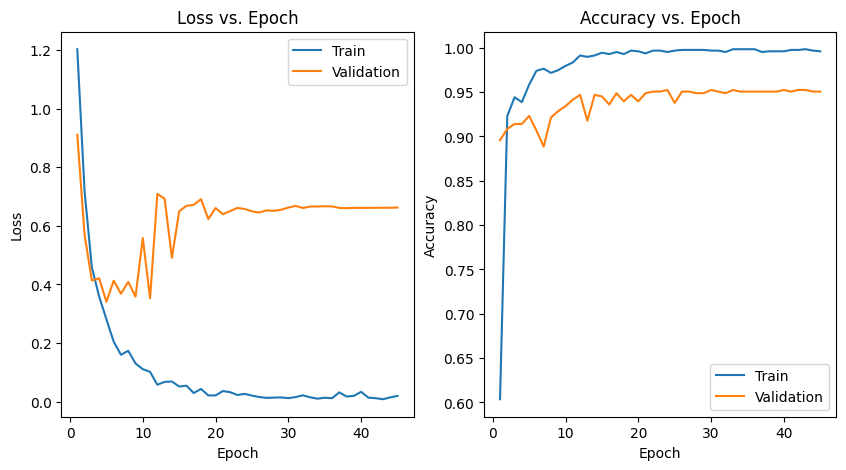

In [24]:
plot_train_proces(num_epochs,
                  model_train_result.train_losses,
                  model_train_result.val_losses,
                  model_train_result.train_accuracies,
                  model_train_result.val_accuracies,
                  'convnexttiny',
                  classification_head_name='head_4')

# Проверка качества лучшей модели на валидационной выборке

Metrics for current model:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       148
           1       0.63      0.59      0.61        29
           2       0.98      0.97      0.98       185
           3       0.98      0.96      0.97       185

    accuracy                           0.95       547
   macro avg       0.88      0.88      0.88       547
weighted avg       0.95      0.95      0.95       547

Test Accuracy: 0.9525


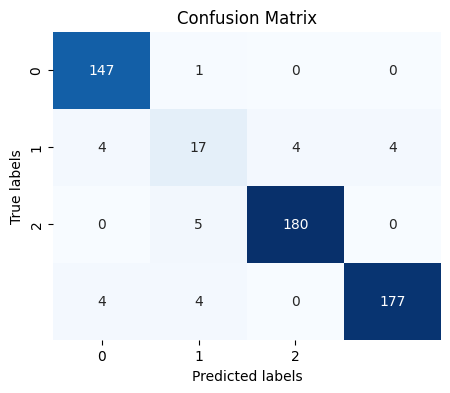

In [12]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader, device)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

# Прогон модели на тестовых данных

In [13]:
test_csv_file = './data/test.csv'
test_images_dir = './data/images'

test_transform = Compose([
                    Resize(height=HEIGHT, width=WIDTH),
                    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                    ToTensorV2()
                ])

test_dataset = CustomDataset(test_csv_file, 
                             test_images_dir, 
                             classes_list, 
                             test_transform, # should be commented to print image
                             is_test=True)

2025-04-06 18:36:55,452 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.2489083].


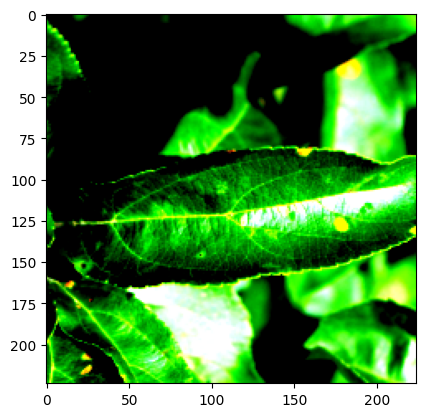

In [14]:
# Убедимся, что в датасет импортировались нужные данные
for image in test_dataset:
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    break

In [15]:
# Определяем загрузчик данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [ ]:
propabilities = []
logits = []

for images in tqdm(test_loader):
    images = images.to(device)
    with torch.no_grad():
        prediction_batch = model(images)
    
    logits_batch = prediction_batch.data.cpu().detach()
    logits.extend(logits_batch.tolist())
    propabilities_batch = F.softmax(logits_batch, dim=1)
    propabilities.extend(propabilities_batch.tolist()) # получили список списков

Testing: 100%|██████████| 29/29 [00:07<00:00,  3.98it/s]

Submission file created successfully!


In [ ]:
for i in range(5):
    print(logits[i])

In [ ]:
for i in range(5):
    print(propabilities[i])

In [ ]:
df = pd.DataFrame(propabilities, columns=classes_list)
df = df.round(4)

In [ ]:
df.head(10)

In [ ]:
submit_df = pd.read_csv(test_csv_file)
submit_df = pd.concat([submit_df, df], axis=1)
submit_df.to_csv('./submission.csv', index=False)